In [1]:
import torch
import numpy as np
import json
from transformers import AutoTokenizer
import networkx as nx
import matplotlib.pyplot as plt
import hierarchical as hrc
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_theme(
    context="paper",
    style="white",  # 'whitegrid', 'dark', 'darkgrid', ...
    palette="colorblind",
    font="DejaVu Sans",  # 'serif'
    font_scale=1.75,  # 1.75, 2, ...
)

In [2]:
device = torch.device("cpu")
# tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
tokenizer = AutoTokenizer.from_pretrained(
    "EleutherAI/pythia-1.4B-deduped",
    revision="step1000",
    cache_dir="./pythia-1.4B-deduped/step1000"
)
g = torch.load('1.4B-unembeddings/step1000').to(device) # 'FILE_PATH' in store_matrices.py

vocab_dict = tokenizer.get_vocab()
vocab_list = [None] * (max(vocab_dict.values()) + 1)
for word, index in vocab_dict.items():
    vocab_list[index] = word

cats, G, sorted_keys = hrc.get_categories('noun')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
import random
alpha = 0.8

num_samples = 100000
torch.random.manual_seed(100)
all_indices = torch.randperm(g.shape[0])
random_ind = all_indices[:num_samples]
random_g = g[random_ind]


error_count = 0
total_count = 0
messed_up = []
proj = {}
for node in sorted_keys:
    total_count += 1
    try:
        lemmas = cats[node]
        random.seed(100)
        random.shuffle(lemmas)

        train_lemmas = lemmas[:int(alpha * len(lemmas))]
        test_lemmas = lemmas[int(alpha * len(lemmas)):]

        estimated_dir = hrc.estimate_cat_dir(train_lemmas, g, vocab_dict)
        estimated_dir = estimated_dir['lda'] / estimated_dir['lda'].norm()

        train_g = g[hrc.category_to_indices(train_lemmas, vocab_dict)]
        test_g = g[hrc.category_to_indices(test_lemmas, vocab_dict)]

        b_lda = (train_g @ estimated_dir).mean()

        proj.update({node: {'train': train_g @ estimated_dir,
                            'test': test_g @ estimated_dir,
                            'random': random_g @ estimated_dir}})
    except Exception as e:
        error_count += 1
        print(e)
        print(node)
        messed_up.append(node)

print(messed_up)
        


torch.Size([2048, 2048])
tensor([[ 1.0365e+00, -1.5005e-03, -9.6383e-04,  ...,  7.0582e-04,
          2.2947e-03, -7.3089e-04],
        [-1.5005e-03,  1.0354e+00, -9.3640e-04,  ...,  6.7168e-04,
         -2.2045e-03, -1.5978e-03],
        [-9.6383e-04, -9.3640e-04,  1.0333e+00,  ..., -4.2008e-04,
         -1.0878e-03, -2.0661e-04],
        ...,
        [ 7.0582e-04,  6.7168e-04, -4.2008e-04,  ...,  1.0336e+00,
         -3.1228e-04,  1.6950e-03],
        [ 2.2947e-03, -2.2045e-03, -1.0878e-03,  ..., -3.1228e-04,
          1.0346e+00, -1.1257e-03],
        [-7.3089e-04, -1.5978e-03, -2.0661e-04,  ...,  1.6950e-03,
         -1.1257e-03,  1.0357e+00]])
torch.Size([2048, 2048])
tensor([[ 1.0360e+00,  3.8057e-04,  9.1657e-04,  ...,  3.0699e-04,
          1.3354e-03, -1.3824e-03],
        [ 3.8057e-04,  1.0346e+00, -1.0349e-03,  ...,  3.0507e-04,
         -1.8116e-03, -1.1108e-03],
        [ 9.1657e-04, -1.0349e-03,  1.0330e+00,  ...,  1.0928e-03,
         -1.1339e-03, -8.7955e-04],
        .

In [5]:
print(sorted_keys)

['entity.n.01', 'physical_entity.n.01', 'abstraction.n.06', 'thing.n.12', 'object.n.01', 'causal_agent.n.01', 'matter.n.03', 'process.n.06', 'psychological_feature.n.01', 'attribute.n.02', 'group.n.01', 'relation.n.01', 'communication.n.02', 'measure.n.02', 'external_body_part.n.01', 'structure.n.04', 'organ.n.01', 'whole.n.02', 'location.n.01', 'part.n.02', 'geological_formation.n.01', 'substance.n.07', 'fluid.n.02', 'solid.n.01', 'phenomenon.n.01', 'organic_process.n.01', 'cognition.n.01', 'event.n.01', 'state.n.02', 'shape.n.02', 'trait.n.01', 'quality.n.01', 'property.n.02', 'arrangement.n.02', 'people.n.01', 'social_group.n.01', 'collection.n.01', 'possession.n.02', 'position.n.07', 'part.n.01', 'magnitude_relation.n.01', 'language.n.01', 'written_communication.n.01', 'message.n.02', 'signal.n.01', 'indication.n.01', 'visual_communication.n.01', 'expressive_style.n.01', 'auditory_communication.n.01', 'fundamental_quantity.n.01', 'definite_quantity.n.01', 'indefinite_quantity.n.01'

In [4]:
for node in messed_up:
    sorted_keys.remove(node)

mean_std = {}
for node in sorted_keys:
    mean_std.update({node: {key: (proj[node][key].mean().cpu().numpy(),
                                  proj[node][key].std().cpu().numpy())
                            for key in ['train', 'test', 'random']} })

KeyError: 'process.n.06'

In [ ]:
train_mean = [mean_std[node]['train'][0] for node in sorted_keys]
train_std = [mean_std[node]['train'][1] for node in sorted_keys]
test_mean = [mean_std[node]['test'][0] for node in sorted_keys]
test_std = [mean_std[node]['test'][1] for node in sorted_keys]
random_mean = [mean_std[node]['random'][0] for node in sorted_keys]
random_std = [mean_std[node]['random'][1] for node in sorted_keys]

In [ ]:
inds = range(len(sorted_keys))
test_train  = [test_mean[i] / train_mean[i] for i in inds]
random_train = [random_mean[i] / train_mean[i] for i in inds]
test_train_std = [test_std[i] / train_mean[i] for i in inds]
random_train_std = [random_std[i] / train_mean[i] for i in inds]

In [ ]:
print(test_train)

[0.90435296, 0.88651323, 0.8781098, 0.54156584, 0.84565246, 0.69251335, 0.6463088, 0.539671, 0.83719474, 0.7450002, 0.692797, 0.6989091, 0.7614002, 0.75642174, 0.21991459, 0.2509125, 0.18744387, 0.84355074, 0.65533125, 0.39106297, 0.23588315, 0.36808115, 0.1346414, 0.2931551, 0.454232, 0.27791834, 0.7616753, 0.79600567, 0.64338124, 0.45236158, 0.2078502, 0.4450789, 0.5778318, 0.44107315, 0.22199993, 0.55250484, 0.4120523, 0.4449247, 0.3396893, 0.6206547, 0.22660041, 0.2544832, 0.6133309, 0.63260186, 0.54414636, 0.40124875, 0.2428468, 0.29455414, 0.389411, 0.441125, 0.62274665, 0.3263467, 0.09238935, 0.3029612, 0.6560964, 0.39759952, 0.8240358, 0.3491136, 0.35470143, 0.48353302, 0.287539, 0.27581224, 0.27561116, 0.44640362, 0.6600667, 0.31409216, 0.7921228, 0.55506915, 0.29259244, 0.24495429, 0.31224644, 0.2667558, 0.3725182, 0.27276614, 0.26807225, 0.20404784, 0.20220456, 0.3789168, 0.35400775, 0.42475075, 0.21718483, 0.25574902, 0.61841756, 0.27645674, 0.35987842, 0.5444295, 0.3185885

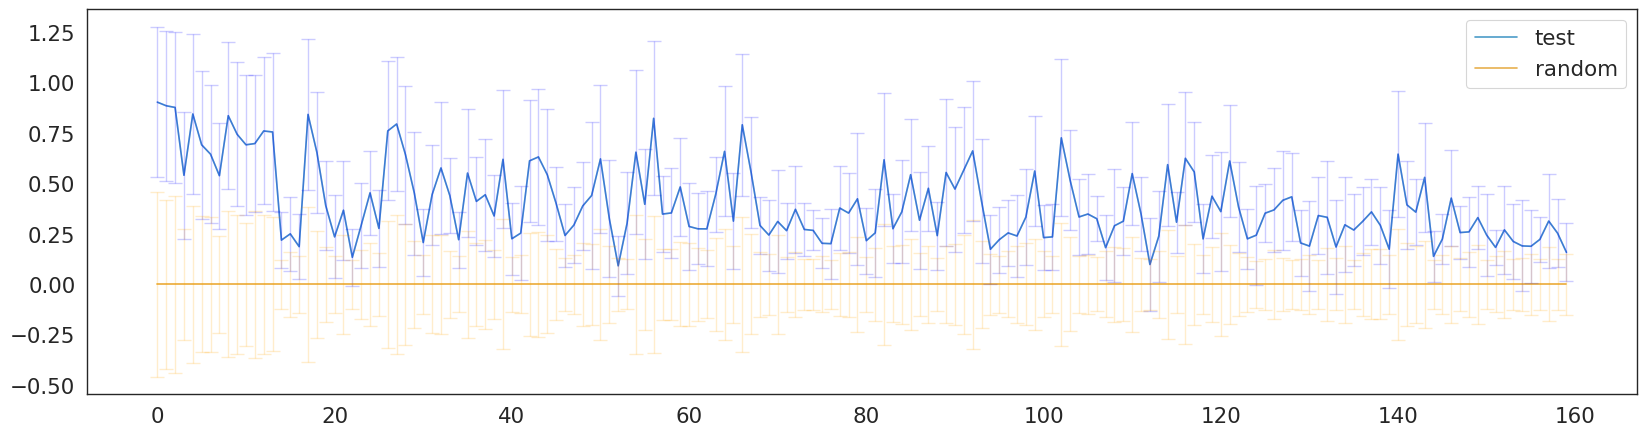

In [ ]:
fig = plt.figure(figsize=(20, 5))
plt.plot(inds, test_train, alpha=0.7, label='test')
plt.plot(inds, random_train, alpha=0.7,label='random')
plt.errorbar(inds, test_train, yerr=test_train_std, color='blue', capsize=5, ecolor='blue', elinewidth=1, alpha=0.2)
plt.errorbar(inds, random_train, yerr=random_train_std, color='orange', capsize=5, ecolor='orange', elinewidth=1, alpha=0.2)
plt.legend()
plt.savefig(f"figures/noun_evaluation.pdf", bbox_inches='tight')
plt.show()